In [1]:
'''Encoded may labels change each time, must be done consistently!'''

'Encoded may labels change each time, must be done consistently!'

In [2]:
from sklearn.preprocessing import LabelEncoder, scale
import pandas as pd
import numpy as np
import pickle
from functions import assign_sets,split_data
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Use Trained Embeddings

In [3]:
#directory='c:/users/da1933/desktop/cds/ids_project/'
directory='/Users/danielamaranto/desktop/idsproject/'

df1=pd.read_csv(directory+'wine/winemag-data-130k-v2.csv',index_col=0)
df2=pd.read_csv(directory+'wine/winemag-data_first150k.csv',index_col=0)
df=pd.concat([df1.drop(['taster_name','taster_twitter_handle','title'],axis=1),df2]).reset_index(drop=True)

df=df[pd.notnull(df['country'])]
df['over90']=df['points'].apply(lambda x: 1 if x>=90 else 0)
df['price']=df['price'].fillna(np.mean(df['price']))
df['price']=scale(df[['price']])

continents=pickle.load(open('continents.sav','rb'))
df['continent']=df['country'].map(continents)
df=df[pd.notnull(df['continent'])]

varietals=df['variety'].value_counts().reset_index().rename(columns={'index':'Grape','variety':'Count'})
varieties=set(varietals[varietals['Count']>2500]['Grape'])
df['variety']=df['variety'].apply(lambda x: x if x in varieties else 'Other')

df['country']=df['country'].replace('US-France','unknown')
df=df[df['country']!='other']
df['name']=df['country']
df['cname']=df['continent']
df['vname']=df['variety']

categorical_features=['country',
                      'variety',
                      'continent']

for i in categorical_features:
    df[i]=df[i].fillna('unknown')

label_encoders = {}
for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        df[cat_col] = label_encoders[cat_col].fit_transform(df[cat_col])
    
df.drop(['description','designation','province','points','region_1','region_2'],axis=1,inplace=True)

In [4]:
# Given a list of 3-d vectors, list(zip(each)) with origin=np.array([0,0,0]) and plot, setting angle for best view
origin=np.array([0,0,0])

_=df.groupby('name').mean()['over90']
country_averages={i:np.round(_[i],3) for i in _.index}

_=df.groupby('cname').mean()['over90']
continent_averages={i:np.round(_[i],3) for i in _.index}

_=df.groupby('vname').mean()['over90']
variety_averages={i:np.round(_[i],3) for i in _.index}

In [5]:
def vec_plot_data(saved_embeddings,feature,name):
    embeddings=pickle.load(open(saved_embeddings,'rb'))
    embed_df=pd.DataFrame.from_dict(embeddings).transpose().reset_index().rename(columns={'index':'target'})
    df['temp']=df[feature].astype(str)+','+df[name]
    embed_df['name']=embed_df['target'].map({int(i.split(sep=',')[0]):i.split(sep=',')[1] for i in set(df['temp'])})
    df.drop('temp',axis=1,inplace=True)
    embed_df=embed_df[pd.notnull(embed_df['name'])]
    variances=[]
    for i in embed_df.columns[1:-1]:
        variances.append((np.std(embed_df[i]),i))
    first,second,third,=sorted(variances)[-3:][0][1],sorted(variances)[-3:][1][1],sorted(variances)[-3:][2][1]
    
    coordinates={embed_df['name'].iloc[i]:list(zip(embed_df[[first,second,third]].iloc[i].values,origin)) \
              for i in embed_df[[first,second,third]].index}
    
    return coordinates

def vec_plot(coordinates,averages,y,x,feature):
    fig = plt.figure(figsize=(15,15))
    fig.figsize=(35,35)
    ax  = fig.add_subplot(111, projection = '3d')
    for i in coordinates.keys():
    #    if (averages[i]<.5)&(averages[i]>.1):
        if averages[i]>=0:
            pt1=coordinates[i][0]
            pt2=coordinates[i][1]
            pt3=coordinates[i][2]
            ax.plot((pt1[0],pt1[1]),(pt2[0],pt2[1]),(pt3[0],pt3[1]),label=i)
            ax.text(pt1[0],pt2[0],pt3[0],averages[i])
        else:
            continue
    
    ax.legend(loc=(-.2,0))
    plt.title('Embedding Vectors and Threshold Average'+' - '+feature)

    ax.view_init(y,x)
    plt.show()
    fig.savefig('/Users/danielamaranto/Desktop/'+feature+'_embed_vecs.png',dpi=300)
    plt.show()
     

In [6]:
countryCoords=vec_plot_data('country_embeddings.p','country','name')
continentCoords=vec_plot_data('continent_embeddings.p','continent','cname')
varietyCoords=vec_plot_data('variety_embeddings.p','variety','vname')

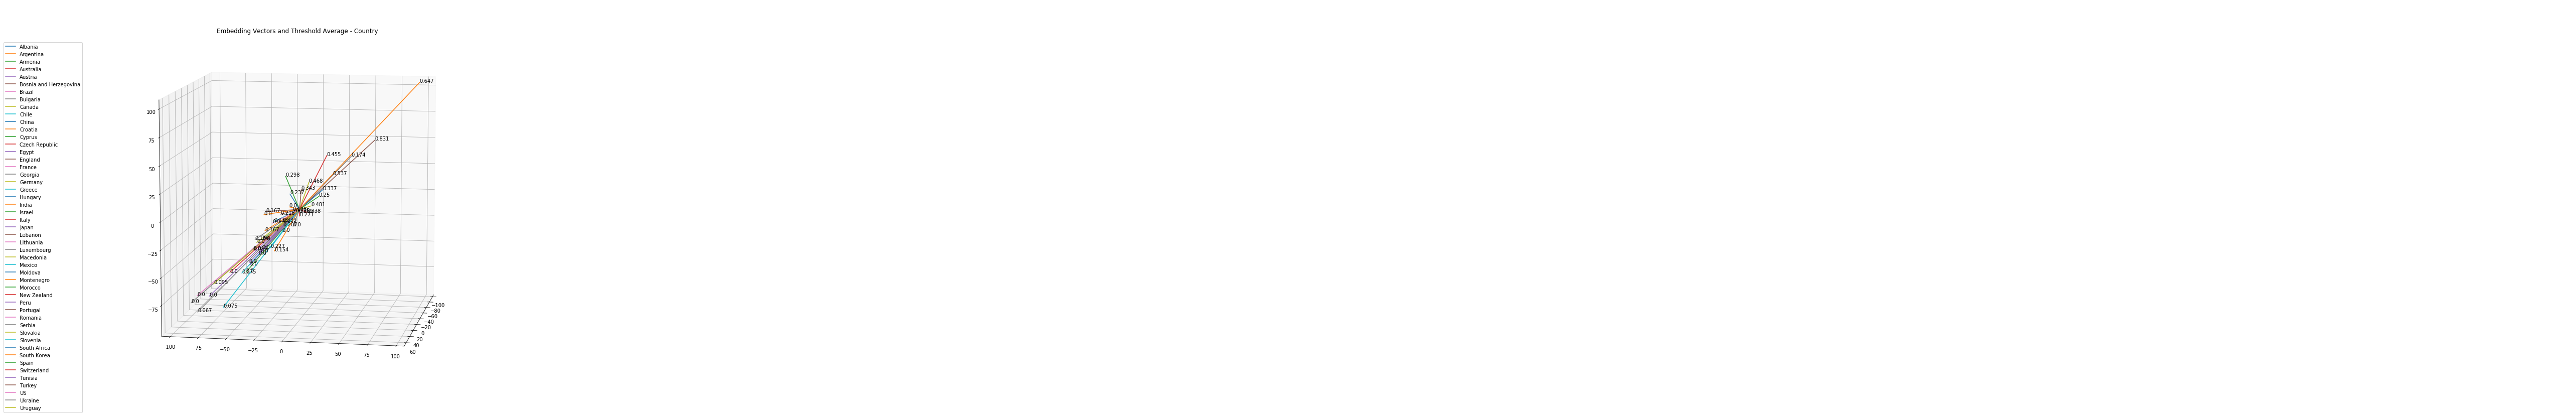

In [7]:
vec_plot(countryCoords,country_averages,10,10,'Country')

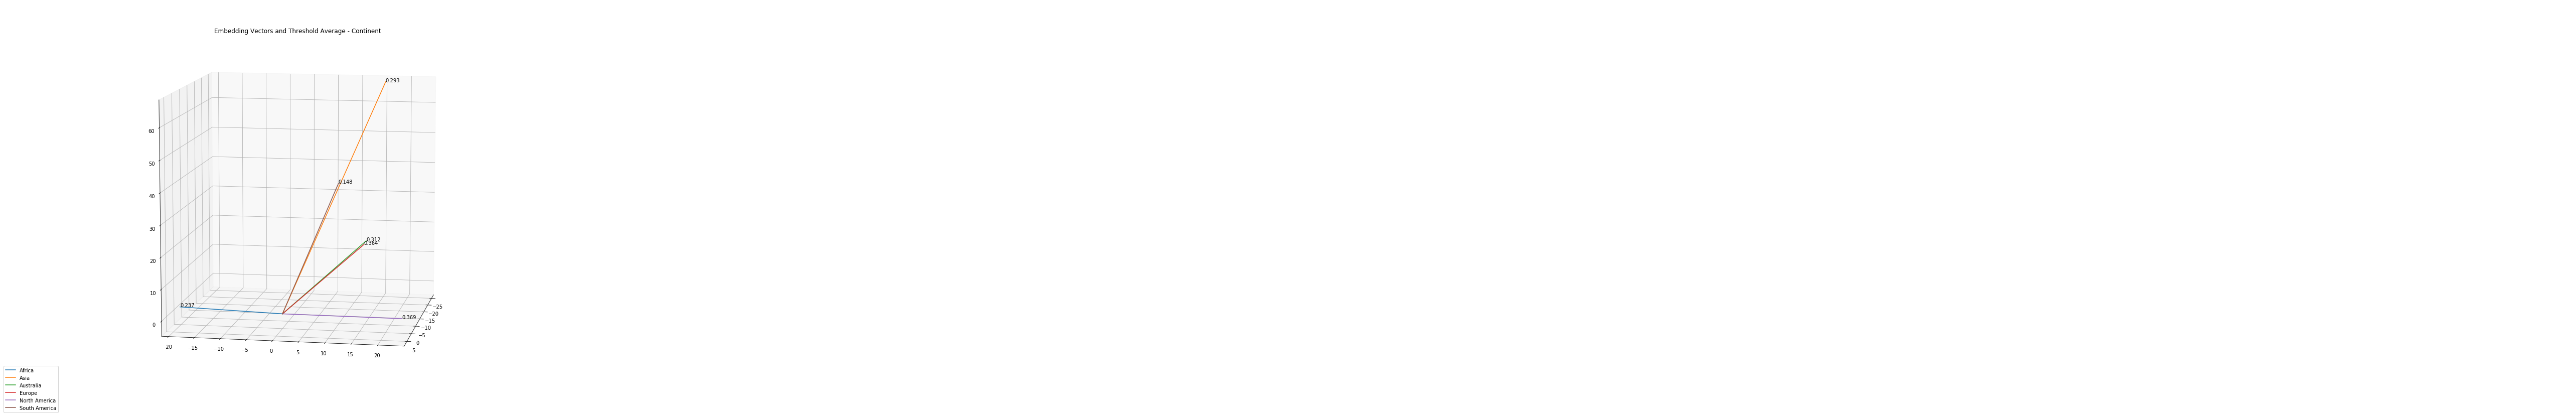

In [8]:
vec_plot(continentCoords,continent_averages,10,10,'Continent')

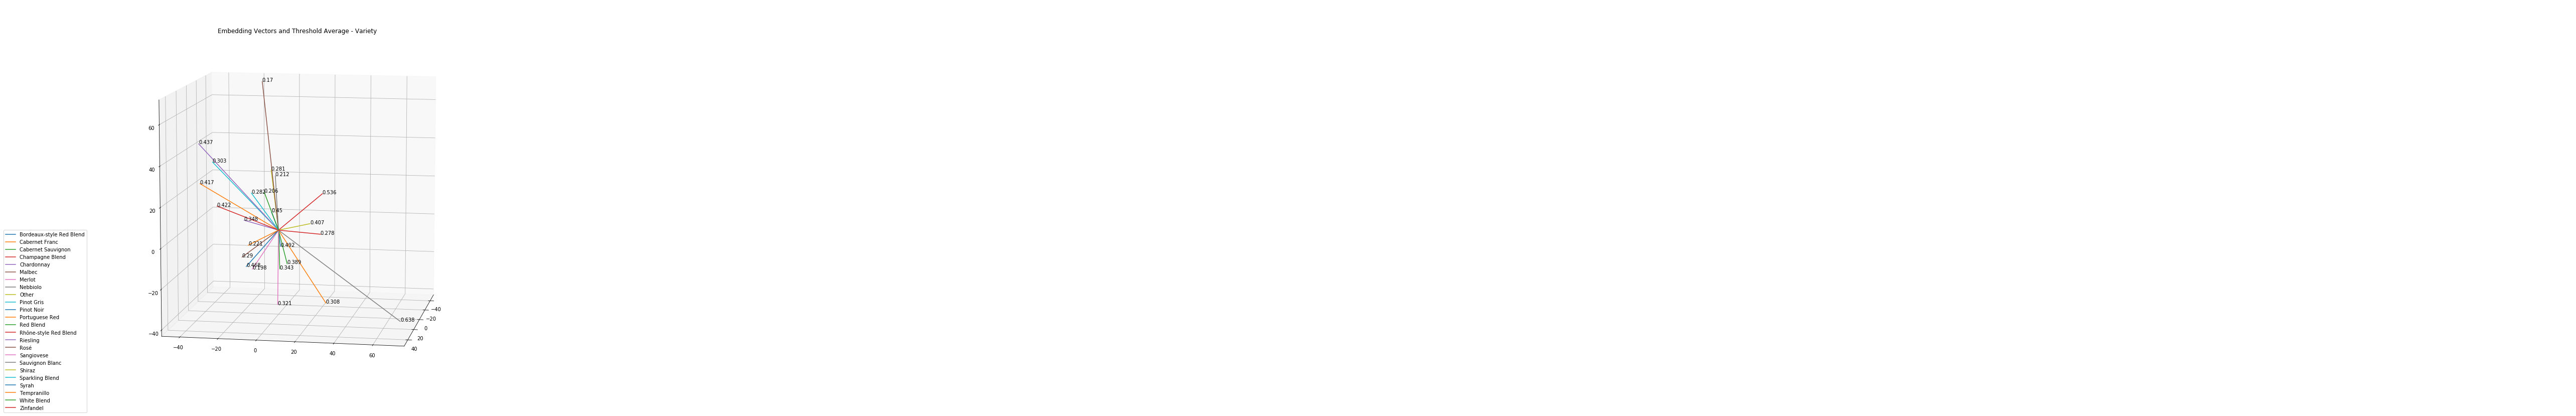

In [9]:
vec_plot(varietyCoords,variety_averages,10,10,'Variety')